<a href="https://colab.research.google.com/github/sweetbaer03/EN_Sentiment-Analysis/blob/main/5_1_FRIENDS_ELECTRA_large(32).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FRIENDS Sentiment Analysis**


ELECTRA_large 모델 사용 

In [1]:
#transformers 설치(colab 사용시)
!pip install transformers

     |████████████████████████████████| 1.5MB 14.1MB/s 
     |████████████████████████████████| 2.9MB 48.7MB/s 
     |████████████████████████████████| 890kB 44.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=dc8f35e6547f56a3c25b35d08c11f7091dea8b7d006e3e3ba71a20999645bb4d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import random
import time
import datetime
import json
import re
import nltk
import matplotlib.pyplot as plt

from transformers import ElectraTokenizer, ElectraForSequenceClassification
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# 데이터처리

In [3]:
!git clone https://github.com/sweetbaer03/EN_Sentiment-Analysis.git

Cloning into 'EN_Sentiment-Analysis'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 80 (delta 42), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (80/80), done.


In [4]:
#파라미터 수정
MAX_LEN = 85
batch_size = 32
epochs = 20

TOKEN_MODEL = 'google/electra-large-discriminator'
TRAIN_MODEL = 'google/electra-large-generator'


## 1.1 프렌즈 / 캐글 테스트 데이터

In [5]:
def jsonToDf(file_name):
  with open(file_name, encoding = 'utf-8', mode = 'r') as file:
    json_array = json.load(file)
  
  result = pd.DataFrame.from_dict(json_array[0])

  is_first = True
  for array in json_array:
    if is_first:
      is_first = False
      continue
    
    temp_df = pd.DataFrame.from_dict(array)
    result = result.append(temp_df, ignore_index = True)

  return result

In [6]:
train_data = jsonToDf('EN_Sentiment-Analysis/data_in/friends_train.json')
dev_data   = jsonToDf('EN_Sentiment-Analysis/data_in/friends_dev.json')
test_data  = jsonToDf('EN_Sentiment-Analysis/data_in/friends_test.json')

In [7]:
#합치기 위해 포멧 통일
train_data.drop(labels=['speaker','annotation'], axis="columns", inplace=True)
dev_data.drop(labels=['speaker','annotation'], axis="columns", inplace=True)
test_data.drop(labels=['speaker','annotation'], axis="columns", inplace=True)

In [8]:
emotions = train_data['emotion'].values

**캐글** 테스트 데이터

In [9]:
test_df = pd.read_csv('EN_Sentiment-Analysis/data_in/en_data.csv')#, encoding = 'unicode_escape')

In [10]:
test_df

,id,i_dialog,i_utterance,speaker,utterance
0,0,0,0,Phoebe,"Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!
...,...,...,...,...,...
1618,1618,150,14,Joey,Nooo.
1619,1619,150,15,Lauren,"Hi, Kate!"
1620,1620,150,16,Kate,"Hi, Lauren."
1621,1621,150,17,Joey,"Hi, Lauren."


### 프랜즈 및 캐글테스트 마스크 처리

프랜즈 데이터 마스크

In [11]:
print(train_data.shape)
print(dev_data.shape)
print(test_data.shape)
print(test_df.shape)

(10561, 2)
(1178, 2)
(2764, 2)
(1623, 5)


In [12]:
def cleaning1(str):
    replaceAll= str
    only_english = re.sub('\x92', '\'', replaceAll)
    return only_english


def getInputsAndLabels(dataset):
  data = dataset.copy(deep=True)

  utterances = data['utterance']
  utterances = ["[CLS] " + str(cleaning1(utterance)) + " [SEP]" for utterance in utterances]#이거다!
  
  encoder = LabelEncoder()
  labels = data['emotion'].values
  encoder.fit(labels)
  labels = encoder.transform(labels)

  tokenizer = ElectraTokenizer.from_pretrained(TOKEN_MODEL, do_lower_case=False)
  tokenized_texts = [tokenizer.tokenize(utterance) for utterance in utterances]

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  return input_ids, labels, attention_masks


def getInputsFromTest(dataset):
  data = dataset.copy(deep=True)

  utterances = data['utterance']
  utterances = ["[CLS] " + str(cleaning1(utterance)) + " [SEP]" for utterance in utterances]#이거다!
  
  tokenizer = ElectraTokenizer.from_pretrained(TOKEN_MODEL, do_lower_case=False)
  tokenized_texts = [tokenizer.tokenize(utterance) for utterance in utterances]

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  return input_ids, attention_masks


def getIndex(dataset):
  data = dataset.copy(deep = True)
  input_index = data.id.tolist()
  return torch.tensor(input_index)

In [13]:
train_inputs1, train_labels1, train_masks1 = getInputsAndLabels(train_data)
dev_inputs, dev_labels, dev_masks = getInputsAndLabels(dev_data)
test_inputs, test_labels, test_masks = getInputsAndLabels(test_data)
test_df_inputs, test_df_masks = getInputsFromTest(test_df)

In [14]:
print('전체 프랜즈 학  습 데이터의 개수: {}'.format(len(train_inputs1)))
print('전체 프랜즈 라  벨 데이터의 개수: {}'.format(len(train_labels1)))
print('전체 프랜즈 마스크 데이터의 개수: {}'.format(len(train_masks1)))

전체 프랜즈 학  습 데이터의 개수: 10561
전체 프랜즈 라  벨 데이터의 개수: 10561
전체 프랜즈 마스크 데이터의 개수: 10561


In [15]:
print('전체 프랜즈 dev학  습 데이터의 개수: {}'.format(len(dev_inputs)))
print('전체 프랜즈 dev라  벨 데이터의 개수: {}'.format(len(dev_labels)))
print('전체 프랜즈 dev마스크 데이터의 개수: {}'.format(len(dev_masks)))

전체 프랜즈 dev학  습 데이터의 개수: 1178
전체 프랜즈 dev라  벨 데이터의 개수: 1178
전체 프랜즈 dev마스크 데이터의 개수: 1178


In [16]:
print('전체 프랜즈 test학  습 데이터의 개수: {}'.format(len(test_inputs)))
print('전체 프랜즈 test라  벨 데이터의 개수: {}'.format(len(test_labels)))
print('전체 프랜즈 test마스크 데이터의 개수: {}'.format(len(test_masks)))

전체 프랜즈 test학  습 데이터의 개수: 2764
전체 프랜즈 test라  벨 데이터의 개수: 2764
전체 프랜즈 test마스크 데이터의 개수: 2764


In [17]:
print('전체 프랜즈 test1 학  습 데이터의 개수: {}'.format(len(test_df_inputs)))
print('전체 프랜즈 test1 마스크 데이터의 개수: {}'.format(len(test_df_masks)))

전체 프랜즈 test1 학  습 데이터의 개수: 1623
전체 프랜즈 test1 마스크 데이터의 개수: 1623


In [18]:
train_masks0 = []
train_masks0.extend(train_masks1)
#train_masks0.extend(train_masks2)
#train_masks0.extend(train_masks3)

In [19]:
train_labels0 = []
train_labels0.extend(train_labels1)
#train_labels0.extend(train_labels2)
#train_labels0.extend(train_labels3)

In [20]:
train_inputs0 = []
train_inputs0.extend(train_inputs1)
#train_inputs0.extend(train_inputs2)
#train_inputs0.extend(train_inputs3)

In [21]:
print('전체 학  습 데이터의 개수: {}'.format(len(train_inputs0)))
print('전체 라  벨 데이터의 개수: {}'.format(len(train_labels0)))
print('전체 마스크 데이터의 개수: {}'.format(len(train_masks0)))

전체 학  습 데이터의 개수: 10561
전체 라  벨 데이터의 개수: 10561
전체 마스크 데이터의 개수: 10561


In [22]:
train_inputs = torch.tensor(train_inputs0)
train_labels = torch.tensor(train_labels0)
train_masks = torch.tensor(train_masks0)

dev_inputs = torch.tensor(dev_inputs)
dev_labels = torch.tensor(dev_labels)
dev_masks = torch.tensor(dev_masks)

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)

test_df_index = getIndex(test_df)
test_df_inputs = torch.tensor(test_df_inputs)
test_df_masks = torch.tensor(test_df_masks)

In [23]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

dev_data = TensorDataset(dev_inputs, dev_masks, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

test_df_data = TensorDataset(test_df_index, test_df_inputs, test_df_masks)
test_df_sampler = RandomSampler(test_df_data)
test_df_dataloader = DataLoader(test_df_data, sampler=test_df_sampler, batch_size=batch_size)

# 2. 모델 구현

In [24]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [25]:
model = ElectraForSequenceClassification.from_pretrained(TRAIN_MODEL, num_labels=8)
model.cuda()

Some weights of the model checkpoint at google/electra-large-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_lm_head.weight', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-large-generator and are newly initializ

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=1024, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linea

In [26]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

#학습

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

#평가함수
def evaluate(true_list, pred_list):

  accuracy = accuracy_score(true_list, pred_list)
  precision = precision_score(true_list, pred_list, average=None)
  recall = recall_score(true_list, pred_list, average=None)
  micro_f1 = f1_score(true_list, pred_list, average='micro')

  print("accuracy:{0:.4f}".format(accuracy))
  print('precision:\t', ['%.4f' % v for v in precision])
  print('recall:\t\t', ['%.4f' % v for v in recall])
  print('micro_f1: %.6f' % micro_f1)

  n_correct = [x for x, y in zip(true_list, pred_list) if x == y]
  cnt_list = [0] * (8)
  for cnt in n_correct:
    if cnt==0:
      cnt_list[cnt]+=1
    elif cnt==1:
      cnt_list[cnt]+=1
    elif cnt==2:
      cnt_list[cnt]+=1
    elif cnt==3:
      cnt_list[cnt]+=1
    elif cnt==4:
      cnt_list[cnt]+=1
    elif cnt==5:
      cnt_list[cnt]+=1
    elif cnt==6:
      cnt_list[cnt]+=1
    elif cnt==7:
      cnt_list[cnt]+=1

  print("각 라벨 별 정답 cnt_list",cnt_list)
  return cnt_list

def matrix_evaluate(true_list, pred_list, cnt_list):
  target_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'non-neutral', 'sadness', 'surprise'] 

  cm = confusion_matrix(true_list, pred_list)
  sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues',) 
  print(classification_report(true_list, pred_list, digits=4, target_names=target_names))
 

In [28]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
             
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.5f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    eval_accuracy, nb_eval_steps = 0, 0
    pred_list, true_list = [], []

    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():     
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
     
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

        pred_flat = np.argmax(logits, axis=1).flatten()
        trues_flat = label_ids.flatten()
        pred_list.extend(pred_flat)
        true_list.extend(trues_flat)

    print("  Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    cnt_list = evaluate(pred_list, true_list) # print results

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...

  Average training loss: 1.75460
  Training epcoh took: 0:00:49

Running Validation...
  Accuracy: 0.46583
  Validation took: 0:00:01
accuracy:0.4660
precision:	 ['0.0000', '0.0000', '0.0000', '0.0000', '0.9450', '0.3972', '0.0000', '0.0000']
recall:		 ['0.0000', '0.0000', '0.0000', '0.0000', '0.5728', '0.2310', '0.0000', '0.0000']
micro_f1: 0.466044
각 라벨 별 정답 cnt_list [0, 0, 0, 0, 464, 85, 0, 0]

======== Epoch 2 / 20 ========
Training...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  Average training loss: 1.46517
  Training epcoh took: 0:00:50

Running Validation...
  Accuracy: 0.47765
  Validation took: 0:00:01
accuracy:0.4779
precision:	 ['0.0000', '0.0000', '0.0000', '0.0000', '0.9226', '0.5140', '0.0000', '0.0000']
recall:		 ['0.0000', '0.0000', '0.0000', '0.0000', '0.6327', '0.2381', '0.0000', '0.0000']
micro_f1: 0.477929
각 라벨 별 정답 cnt_list [0, 0, 0, 0, 453, 110, 0, 0]

======== Epoch 3 / 20 ========
Training...

  Average training loss: 1.37875
  Training epcoh took: 0:00:50

Running Validation...
  Accuracy: 0.47953
  Validation took: 0:00:01
accuracy:0.4796
precision:	 ['0.0000', '0.0000', '0.0000', '0.0569', '0.9409', '0.4393', '0.0323', '0.0000']
recall:		 ['0.0000', '0.0000', '0.0000', '0.2333', '0.6063', '0.2448', '1.0000', '0.0000']
micro_f1: 0.479626
각 라벨 별 정답 cnt_list [0, 0, 0, 7, 462, 94, 2, 0]

======== Epoch 4 / 20 ========
Training...

  Average training loss: 1.31151
  Training epcoh took: 0:00:49

Running Validation...
  Accuracy: 0.49753
 

# 평가

In [29]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
f1_score_avg = []
pred_list, true_list = [], []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for step, batch in enumerate(test_dataloader):
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    trues_flat = label_ids.flatten()
    pred_list.extend(pred_flat)
    true_list.extend(trues_flat)
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("  Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))
print("Emotion accuracy")
cnt_list = evaluate(pred_list, true_list) # print results



  Accuracy: 0.54083
Test took: 0:00:02
Emotion accuracy
accuracy:0.5405
precision:	 ['0.2174', '0.0000', '0.0000', '0.6513', '0.7436', '0.2791', '0.2471', '0.4615']
recall:		 ['0.3241', '0.0000', '0.0000', '0.4541', '0.7234', '0.2921', '0.2143', '0.4681']
micro_f1: 0.540521
각 라벨 별 정답 cnt_list [35, 0, 0, 198, 957, 151, 21, 132]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<BarContainer object of 8 artists>

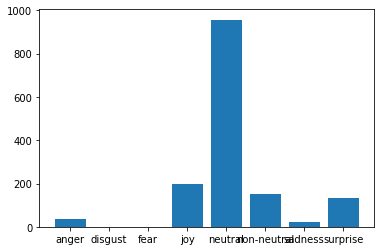

In [30]:
target_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'non-neutral', 'sadness', 'surprise']
plt.bar(target_names,cnt_list)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger     0.2174    0.3241    0.2602       108
     disgust     0.0000    0.0000    0.0000         0
        fear     0.0000    0.0000    0.0000         0
         joy     0.6513    0.4541    0.5351       436
     neutral     0.7436    0.7234    0.7333      1323
 non-neutral     0.2791    0.2921    0.2854       517
     sadness     0.2471    0.2143    0.2295        98
    surprise     0.4615    0.4681    0.4648       282

    accuracy                         0.5405      2764
   macro avg     0.3250    0.3095    0.3136      2764
weighted avg     0.5752    0.5405    0.5545      2764



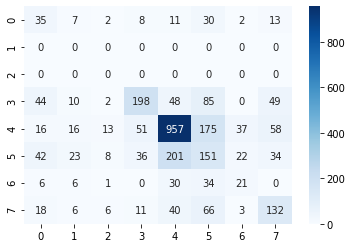

In [31]:
matrix_evaluate(pred_list, true_list, cnt_list)

# test 결과물

In [ ]:
tmp_test_dataloader = DataLoader(test_df_data, sampler=test_df_sampler, batch_size=1)
test_result = test_df.copy(deep = True)
test_result = test_result.drop(columns = ['i_dialog', 'i_utterance', 'speaker'])
test_result['Predicted'] = 'default'
classes = [0,1,2,3,4,5,6,7]

encoder = LabelEncoder()
classes = emotions
encoder.fit(classes)
classes = encoder.transform(classes)

#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(tmp_test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(tmp_test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_index, b_input_ids, b_input_mask = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    idx = b_index.item()
    test_result['Predicted'][idx] = encoder.classes_[np.argmax(logits)]
    

    nb_eval_steps += 1

print("")
print("Test took: {:}".format(format_time(time.time() - t0)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  Batch   100  of  1,623.    Elapsed: 0:00:01.
  Batch   200  of  1,623.    Elapsed: 0:00:02.
  Batch   300  of  1,623.    Elapsed: 0:00:04.
  Batch   400  of  1,623.    Elapsed: 0:00:05.
  Batch   500  of  1,623.    Elapsed: 0:00:06.
  Batch   600  of  1,623.    Elapsed: 0:00:07.
  Batch   700  of  1,623.    Elapsed: 0:00:09.
  Batch   800  of  1,623.    Elapsed: 0:00:10.
  Batch   900  of  1,623.    Elapsed: 0:00:11.
  Batch 1,000  of  1,623.    Elapsed: 0:00:12.
  Batch 1,100  of  1,623.    Elapsed: 0:00:13.
  Batch 1,200  of  1,623.    Elapsed: 0:00:14.
  Batch 1,300  of  1,623.    Elapsed: 0:00:16.
  Batch 1,400  of  1,623.    Elapsed: 0:00:17.
  Batch 1,500  of  1,623.    Elapsed: 0:00:18.
  Batch 1,600  of  1,623.    Elapsed: 0:00:19.

Test took: 0:00:19


In [ ]:
test_result['Predicted']

0           neutral
1               joy
2             anger
3           neutral
4       non-neutral
           ...     
1618        neutral
1619            joy
1620        neutral
1621        neutral
1622          anger
Name: Predicted, Length: 1623, dtype: object

In [ ]:
test_result

,id,utterance,Predicted
0,0,"Alright, whadyou do with him?",neutral
1,1,Oh! You're awake!,joy
2,2,Then you gotta come clean with Ma! This is not...,anger
3,3,"Yeah, but this is",neutral
4,4,I don't wanna hear it! Now go to my room!,non-neutral
...,...,...,...
1618,1618,Nooo.,neutral
1619,1619,"Hi, Kate!",joy
1620,1620,"Hi, Lauren.",neutral
1621,1621,"Hi, Lauren.",neutral


In [ ]:
test_result.drop(labels='utterance', axis="columns", inplace=True)

In [ ]:
test_csv = test_result.to_csv('submission_bert_uncase_20.csv', columns=['id', 'Predicted'], index=False)
from google.colab import files

files.download('submission_bert_uncase_20.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>